### First We Import Our Important Libraries

In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

### This cell is rather an interactive cell that will display the percentage completion of videos while we are uploading them

In [2]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

### Now we are just saving the directory where our training videos are.

In [3]:
in_dir="/content/drive/MyDrive/data"

### Now that we have the data directory, since here we are analysing videos. We see that we need setup the frames sizes in order to avoid any form of inconvienience later.

In [4]:
img_size = 224
img_size_touple = (img_size, img_size)
num_channels = 3
img_size_flat = img_size * img_size * num_channels
num_classes = 2
_num_files_train = 1
_images_per_file = 20
_num_images_train = _num_files_train * _images_per_file
video_exts = ".avi"

###Function below used to get 20 frames from a video file and convert the frame to a suitable format for the neural net.

In [5]:
def get_frames(current_dir, file_name):

    in_file = os.path.join(current_dir, file_name)

    images = []

    vidcap = cv2.VideoCapture(in_file)

    success,image = vidcap.read()

    count = 0

    while count<_images_per_file:

        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)

        images.append(res)

        success,image = vidcap.read()

        count += 1

    resul = np.array(images)

    resul = (resul / 255.).astype(np.float16)

    return resul

###We have 1000 video dataset. This code will access each video, and will start labeling them as fight or no fight scenes

In [6]:
def label_video_names(in_dir):
    names = []
    labels = []

    for current_dir, dir_names,file_names in os.walk(in_dir):

        for file_name in file_names:

            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)


    c = list(zip(names,labels))
    shuffle(c)
    names, labels = zip(*c)
    return names, labels

###Now we access our label video function and get our labeled data

In [7]:
names, labels = label_video_names(in_dir)

###Now we import our most important model that does all the behind the scenes work. The VGG19 model.

In [8]:
image_model = VGG19(include_top=True, weights='imagenet')

574710816/574710816 [==============================] - 5s 0us/step


### Now this is the time we select the layer whose output we are going to use finally for the classification purpose.

In [9]:
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG19 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG19 net have dimensions: ", transfer_values_size)

The input of the VGG19 net have dimensions: (224, 224)
The output of the selecter layer of VGG19 net have dimensions:  4096


###The function below recieves the 20 frames belonging to a particular video, processes it via the VGG 19 model and returns the transfer values

In [10]:
def get_transfer_values(current_dir, file_name):
    shape = (_images_per_file,) + img_size_touple + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    image_batch = get_frames(current_dir, file_name)
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)
    transfer_values = \
            image_model_transfer.predict(image_batch)
    return transfer_values

###Now below is a function that select on video at a time, breaks it into 20 frames and passes it into previous function to generate transfer value in the first place.

In [11]:
def proces_transfer(vid_names, in_dir, labels):
    count = 0
    tam = len(vid_names)
    shape = (_images_per_file,) + img_size_touple + (3,)
    while count<tam:
        video_name = vid_names[count]
        image_batch = np.zeros(shape=shape, dtype=np.float16)
        image_batch = get_frames(in_dir, video_name)
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        transfer_values = \
            image_model_transfer.predict(image_batch)
        labels1 = labels[count]
        aux = np.ones([20,2])
        labelss = labels1*aux
        yield transfer_values, labelss
        count+=1

###There are two functions below. Thier only function is to store transfer values for later use. The first function stores transfer data for training set and the second function stores transfer data for the third set.

In [12]:
def make_files(n_files):
    gen = proces_transfer(names_training, in_dir, labels_training)
    numer = 1
    chunk = next(gen)
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    with h5py.File('prueba.h5', 'w') as f:
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
        dset[:] = chunk[0]
        dset2[:] = chunk[1]
        for chunk in gen:
            if numer == n_files:
                break
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
            numer += 1



def make_files_test(n_files):

    gen = proces_transfer(names_test, in_dir, labels_test)
    numer = 1
    chunk = next(gen)
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    with h5py.File('pruebavalidation.h5', 'w') as f:
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
        dset[:] = chunk[0]
        dset2[:] = chunk[1]
        for chunk in gen:
            if numer == n_files:
                break
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
            numer += 1

###Spliting our data into train and test set

In [13]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

### Here we have been trying to get transfer values for both test and training set

In [14]:
make_files(training_set)

1/1 [==============================] - 15s 15s/step
- Progress: 99.9%

In [16]:
make_files_test(test_set)

1/1 [==============================] - 15s 15s/step
- Progress: 99.5%

###Load cache memory of transfer values to feed into LSTM for training and testing. Below two function do the exact thing

In [17]:
def process_alldata_training():
    joint_transfer=[]
    frames_num=20
    count = 0
    with h5py.File('prueba.h5', 'r') as f:
        X_batch = f['data'][:]
        y_batch = f['labels'][:]
    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
    data =[]
    target=[]
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
    return data, target



def process_alldata_test():
    joint_transfer=[]
    frames_num=20
    count = 0
    with h5py.File('pruebavalidation.h5', 'r') as f:
        X_batch = f['data'][:]
        y_batch = f['labels'][:]
    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
    data =[]
    target=[]
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
    return data, target

In [18]:
data, target = process_alldata_training()

In [19]:
data_test, target_test = process_alldata_test()

###Now we define our LSTM Model

In [20]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

###Now we train Our Model

In [21]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])),
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 20s - loss: 0.3206 - accuracy: 0.4944 - val_loss: 0.3197 - val_accuracy: 0.5125 - 20s/epoch - 10s/step
Epoch 2/200
2/2 - 15s - loss: 0.3115 - accuracy: 0.5139 - val_loss: 0.2981 - val_accuracy: 0.4875 - 15s/epoch - 7s/step
Epoch 3/200
2/2 - 15s - loss: 0.2784 - accuracy: 0.5111 - val_loss: 0.2507 - val_accuracy: 0.5125 - 15s/epoch - 7s/step
Epoch 4/200
2/2 - 15s - loss: 0.2544 - accuracy: 0.4889 - val_loss: 0.2468 - val_accuracy: 0.5125 - 15s/epoch - 7s/step
Epoch 5/200
2/2 - 15s - loss: 0.2477 - accuracy: 0.5722 - val_loss: 0.2490 - val_accuracy: 0.4875 - 15s/epoch - 7s/step
Epoch 6/200
2/2 - 15s - loss: 0.2475 - accuracy: 0.5111 - val_loss: 0.2461 - val_accuracy: 0.4875 - 15s/epoch - 7s/step
Epoch 7/200
2/2 - 14s - loss: 0.2422 - accuracy: 0.6125 - val_loss: 0.2362 - val_accuracy: 0.6000 - 14s/epoch - 7s/step
Epoch 8/200
2/2 - 14s - loss: 0.2361 - accuracy: 0.5625 - val_loss: 0.2287 - val_accuracy: 0.8375 - 14s/epoch - 7s/step
Epoch 9/200
2/2 - 15s - loss: 0.2262 - 

### Now we test the Model

In [22]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 2s 295ms/step - loss: 0.0740 - accuracy: 0.9150


###Loss And Accuracy

In [23]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.07400532066822052
accuracy 0.9150000214576721


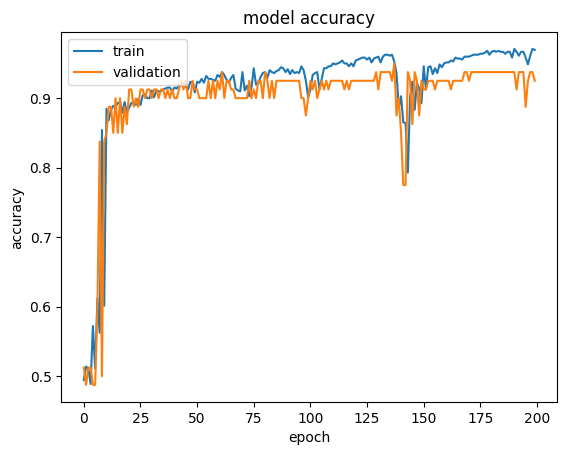

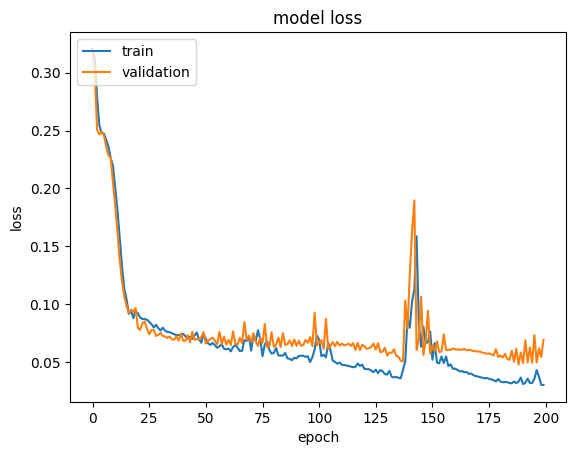

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()